<a href="https://colab.research.google.com/github/SPThole/pyTrch/blob/master/share_price_predictions_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

In [2]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
from tqdm.notebook import tqdm
import torch.nn as nn
import yfinance as yf
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
today_date = date.today()
today_date = str(today_date)

In [5]:
company = 'SPY'
getit = yf.Ticker(company)

data = getit.history(period='2y')

In [6]:
#already in date time format
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 504 entries, 2018-10-03 to 2020-10-02
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          504 non-null    float64
 1   High          504 non-null    float64
 2   Low           504 non-null    float64
 3   Close         504 non-null    float64
 4   Volume        504 non-null    int64  
 5   Dividends     504 non-null    float64
 6   Stock Splits  504 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 31.5 KB


In [7]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-10-03,281.59,282.04,280.22,280.61,64694600,0.0,0
2018-10-04,280.09,280.15,276.70,278.42,111545900,0.0,0
2018-10-05,278.66,279.21,275.32,276.86,105951700,0.0,0
2018-10-08,276.12,277.24,274.63,276.86,87742200,0.0,0
2018-10-09,276.44,277.86,275.85,276.45,74339000,0.0,0


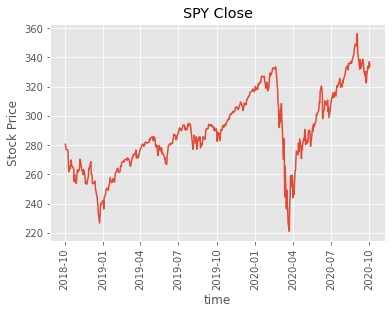

In [8]:
colp = 'Close'

plt.style.use('ggplot')

plt.plot(data['Close'])
plt.xticks(rotation = 'vertical')
plt.title(company + ' ' + colp)
plt.xlabel('time')
plt.ylabel('Stock Price')
plt.show()

In [9]:
input = torch.randn(12,100,1)
lstm = nn.LSTM(input_size = 1, hidden_size =512 , batch_first = True)

output, _ =lstm(input)

In [10]:
output.reshape(100, 12, 512)[-1].shape

torch.Size([12, 512])

In [11]:
scaler = MinMaxScaler()

hist_data = data['Close'].values

hist_data = scaler.fit_transform(hist_data.reshape(-1,1))

In [12]:
def slider_timeframe(window_size,data):

  vals = data.copy()

  xs = []
  ys = []

  for i in range(0,len(vals)-window_size):

    xs.append(vals[i:i+window_size])
    ys.append(vals[i+window_size])

  return np.array(xs),np.array(ys)

In [13]:


window_size = 5
x,y = slider_timeframe(window_size,hist_data)


In [14]:
hist_data,x,y

(array([[0.44030182],
        [0.4241012 ],
        [0.41256103],
        [0.41256103],
        [0.40952804],
        [0.34479953],
        [0.30115402],
        [0.32808108],
        [0.31705874],
        [0.35974257],
        [0.36011244],
        [0.33126202],
        [0.33022636],
        [0.32142329],
        [0.3114366 ],
        [0.2524042 ],
        [0.28628495],
        [0.25247818],
        [0.24204764],
        [0.26986241],
        [0.29020565],
        [0.31069685],
        [0.29915668],
        [0.30988312],
        [0.32216304],
        [0.36410712],
        [0.36048232],
        [0.3409528 ],
        [0.30403906],
        [0.30041426],
        [0.28717266],
        [0.30722   ],
        [0.31225033],
        [0.27933126],
        [0.24389703],
        [0.25033289],
        [0.23768309],
        [0.26793904],
        [0.27437491],
        [0.31831632],
        [0.31409972],
        [0.32593579],
        [0.35190117],
        [0.28754254],
        [0.28458352],
        [0

In [15]:
x.shape,y.shape

((499, 5, 1), (499, 1))

In [16]:
x_train_size = int(0.75*len(x))

x_test_size = len(x) -x_train_size

scaler = MinMaxScaler()

x_train = x[:x_train_size]

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y[:x_train_size]).float()

x_test = x[x_train_size:]

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y[x_train_size:]).float()

In [17]:
x_test.shape, y_train.shape

(torch.Size([125, 5, 1]), torch.Size([374, 1]))

In [18]:
class tsData(Dataset):
  def __init__(self,x,y):
    self.x = x
    self.y = y

  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]

  def __len__(self):
    return len(self.x)

In [19]:
class tsmodel(nn.Module):

  def __init__(self,
               features,
               horizon,
               seq_len,
               hidden_size,
               num_layers):
    
    super(tsmodel,self).__init__()

    self.features = features
    self.horizon = horizon
    self.seq_len = seq_len
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.rnn = nn.LSTM(input_size = self.features, 
                       hidden_size = self.hidden_size, 
                       dropout = 0.4,
                       num_layers = self.num_layers,
                       
                       )
    
    self.linear = nn.Linear(self.hidden_size,
                            self.horizon)

  def forward(self,x):

    h_0 = torch.zeros(self.num_layers, self.seq_len, self.hidden_size).to(device)
    c_0 = torch.zeros(self.num_layers, self.seq_len, self.hidden_size).to(device)
    
    out,_ = self.rnn(x,(h_0,c_0))

    #print(out.shape)

    out = out.reshape(self.seq_len, x.size(0), self.hidden_size)

    #print(out[-1].shape)

    out = self.linear(out[-1])

    #print(out.shape)

    return out


In [20]:
TSmodel = tsmodel(1, 1, window_size, 512, 1).to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [21]:
optimizer = torch.optim.Adam(TSmodel.parameters(),lr=1e-3)

loss_func = nn.MSELoss().to(device)

In [22]:
def trainer(model, loader, optimizer,epoch):
  l = []
  for i, X in enumerate(loader):
     
  

    x, y = X

    x = x.to(device)
    y = y.to(device)

    output = model(x)

    loss = loss_func(output, y)

    loss.backward()

    optimizer.step()

    optimizer.zero_grad()

    l.append(loss.item())
  
  if epoch%50==0:
    print('__________________________________________________\n')
    print(f'Training loss\t\t\t {np.mean(l)}')
    print('__________________________________________________\n')

def evaluer(model, loader):
  l = []
  for i, X in enumerate(loader):

    x, y = X

    x = x.to(device)
    y = y.to(device)

    output = model(x)

    loss = loss_func(output, y)

    l.append(loss.item())

  print('__________________________________________________\n')
  print(f'loss\t\t\t {np.mean(l)}')
  print('__________________________________________________\n')

In [23]:
train_dataset = tsData(x_train, y_train)
test_dataset = tsData(x_test, y_test)


train_loader = DataLoader(train_dataset, 16)
test_loader = DataLoader(test_dataset,16)

In [24]:
def trainTSmodel(model,train_loader,optimizer,epochs):

  for epoch in tqdm(range(epochs)):

    trainer(model,train_loader,optimizer,epoch)



In [25]:
trainTSmodel(TSmodel,train_loader,optimizer,500)

__________________________________________________

Training loss			 0.01705526489483115
__________________________________________________

__________________________________________________

Training loss			 0.002208370053267572
__________________________________________________

__________________________________________________

Training loss			 0.004152274535954348
__________________________________________________

__________________________________________________

Training loss			 0.0024850120959551227
__________________________________________________

__________________________________________________

Training loss			 0.002294513148929885
__________________________________________________

__________________________________________________

Training loss			 0.0029987346303338804
__________________________________________________

__________________________________________________

Training loss			 0.002211387938586995
__________________________________________________

_____

In [26]:
evaluer(TSmodel,test_loader)

__________________________________________________

loss			 0.0023648752394365147
__________________________________________________



In [27]:
def predictor(model, loader):
  l = []
  for i, X in enumerate(loader):

    x, y = X

    x = x.to(device)
    y = y.to(device)

    output = model(x)

    

    l.extend(output.tolist())

  return np.array(l).reshape(-1,)




In [28]:
out_train = predictor(TSmodel,train_loader)
out_test  = predictor(TSmodel,test_loader)

In [29]:
# hist_data.index[:x_train_size].shape
scaler.fit(data['Close'].values.reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [30]:
out_train = scaler.inverse_transform(np.array(out_train).reshape(-1,1))
out_test = scaler.inverse_transform(np.array(out_test).reshape(-1,1))

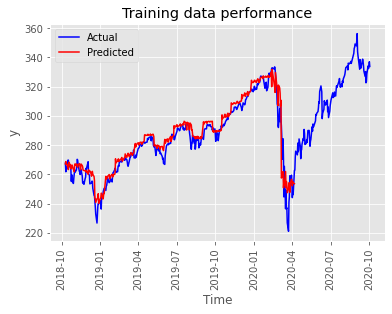

In [33]:
plt.plot(data['Close'].iloc[window_size:],color='b',label='Actual')
plt.plot(data.index[window_size:x_train_size+window_size],np.array(out_train),color='r',label='Predicted')
plt.title('Training data performance')
plt.xlabel('Time')
plt.ylabel('y')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

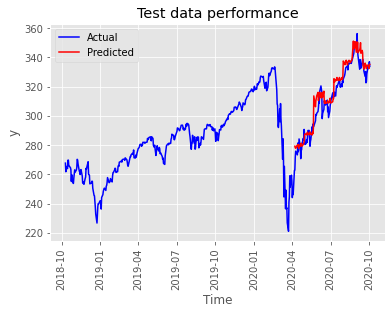

In [34]:
plt.plot(data['Close'].iloc[window_size:],color='b',label='Actual')
plt.plot(data.index[x_train_size+window_size:],np.array(out_test),color='r',label='Predicted')
plt.title('Test data performance')
plt.xlabel('Time')
plt.xticks(rotation='vertical')
plt.ylabel('y')
plt.legend()
plt.show()